# Proyek: Sistem Rekomendasi Movie

## Pendahuluan
Proyek ini bertujuan untuk membangun sistem rekomendasi film menggunakan dataset MovieLens. Sistem ini akan menyajikan rekomendasi berdasarkan dua pendekatan:
1. **Content-based Filtering**: Merekomendasikan film berdasarkan kemiripan genre.
2. **Collaborative Filtering**: Merekomendasikan film berdasarkan preferensi pengguna lain yang mirip.

## Data Understanding
Tahap ini melibatkan pengunduhan dataset, pemuatan data ke dalam dataframe, dan eksplorasi data (EDA).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
import os
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Konfigurasi visualisasi
sns.set(style='whitegrid')
%matplotlib inline

### Mengunduh Dataset
Kita akan menggunakan dataset MovieLens Small yang tersedia secara publik.

In [2]:
import urllib.request
url = 'https://files.grouplens.org/datasets/movielens/ml-latest-small.zip'
filename = 'ml-latest-small.zip'
urllib.request.urlretrieve(url, filename)

# Ekstrak file zip
local_zip = 'ml-latest-small.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('.')
zip_ref.close()

base_dir = 'ml-latest-small'

### Memuat Data & Data Understanding


In [3]:
movies = pd.read_csv(f'{base_dir}/movies.csv')
ratings = pd.read_csv(f'{base_dir}/ratings.csv')
links = pd.read_csv(f'{base_dir}/links.csv')
tags = pd.read_csv(f'{base_dir}/tags.csv')

print("Movies Shape:", movies.shape)
print("Ratings Shape:", ratings.shape)
print("Links Shape:", links.shape)
print("Tags Shape:", tags.shape)

Movies Shape: (9742, 3)
Ratings Shape: (100836, 4)
Links Shape: (9742, 3)
Tags Shape: (3683, 4)


### Movies Variable


In [4]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9742 non-null   int64 
 1   title    9742 non-null   object
 2   genres   9742 non-null   object
dtypes: int64(1), object(2)
memory usage: 228.5+ KB


In [5]:
print('Banyak data: ', len(movies.movieId.unique()))
print('Jumlah judul: ', len(movies.title.unique()))
print('Jenis genre: ', movies.genres.unique())

Banyak data:  9742
Jumlah judul:  9737
Jenis genre:  ['Adventure|Animation|Children|Comedy|Fantasy'
 'Adventure|Children|Fantasy' 'Comedy|Romance' 'Comedy|Drama|Romance'
 'Comedy' 'Action|Crime|Thriller' 'Adventure|Children' 'Action'
 'Action|Adventure|Thriller' 'Comedy|Horror'
 'Adventure|Animation|Children' 'Drama' 'Action|Adventure|Romance'
 'Crime|Drama' 'Drama|Romance' 'Action|Comedy|Crime|Drama|Thriller'
 'Comedy|Crime|Thriller' 'Crime|Drama|Horror|Mystery|Thriller'
 'Drama|Sci-Fi' 'Children|Drama' 'Adventure|Drama|Fantasy|Mystery|Sci-Fi'
 'Mystery|Sci-Fi|Thriller' 'Children|Comedy' 'Drama|War'
 'Action|Crime|Drama' 'Action|Adventure|Fantasy' 'Comedy|Drama|Thriller'
 'Mystery|Thriller' 'Animation|Children|Drama|Musical|Romance'
 'Crime|Mystery|Thriller' 'Adventure|Drama' 'Drama|Thriller'
 'Comedy|Crime' 'Action|Sci-Fi|Thriller' 'Action|Comedy|Horror|Thriller'
 'Comedy|Drama' 'Documentary' 'Action|Crime|Drama|Thriller'
 'Crime|Drama|Romance' 'Action|Adventure|Drama' 'Action|Thrill

### Ratings Variable

In [6]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


In [7]:
print('Jumlah user: ', len(ratings.userId.unique()))
print('Jumlah movie: ', len(ratings.movieId.unique()))
print('Jumlah rating: ', len(ratings.rating.unique()))
print('Jumlah timestamp: ', len(ratings.timestamp.unique()))

Jumlah user:  610
Jumlah movie:  9724
Jumlah rating:  10
Jumlah timestamp:  85043


In [8]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


### Links Variable

In [9]:
links.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   movieId  9742 non-null   int64  
 1   imdbId   9742 non-null   int64  
 2   tmdbId   9734 non-null   float64
dtypes: float64(1), int64(2)
memory usage: 228.5 KB


### Tags variable

In [10]:
tags.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3683 entries, 0 to 3682
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   userId     3683 non-null   int64 
 1   movieId    3683 non-null   int64 
 2   tag        3683 non-null   object
 3   timestamp  3683 non-null   int64 
dtypes: int64(3), object(1)
memory usage: 115.2+ KB


In [11]:
print("Jumlah user: ", len(tags.userId.unique()))
print("Jumlah movie: ", len(tags.movieId.unique()))
print("Jumlah tag: ", len(tags.tag.unique()))
print("Jumlah timestamp: ", len(tags.timestamp.unique()))


Jumlah user:  58
Jumlah movie:  1572
Jumlah tag:  1589
Jumlah timestamp:  3411


In [12]:
tags.head()

,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200


## Data Preparation


### Menangani Missing dan duplicate Values
Cek apakah ada nilai yang hilang.

In [13]:
print("Missing values in Movies:")
print(movies.isnull().sum())

print("\nMissing values in Ratings:")
print(ratings.isnull().sum())

print("\nMissing values in Links:")
print(links.isnull().sum())

print("\nMissing values in Tags:")
print(tags.isnull().sum())



Missing values in Movies:
movieId    0
title      0
genres     0
dtype: int64

Missing values in Ratings:
userId       0
movieId      0
rating       0
timestamp    0
dtype: int64

Missing values in Links:
movieId    0
imdbId     0
tmdbId     8
dtype: int64

Missing values in Tags:
userId       0
movieId      0
tag          0
timestamp    0
dtype: int64


In [14]:
print("Missing values in Movies:")
print(movies.duplicated().sum())

print("\nMissing values in Ratings:")
print(ratings.duplicated().sum())

print("\nMissing values in Links:")
print(links.duplicated().sum())

print("\nMissing values in Tags:")
print(tags.duplicated().sum())



Missing values in Movies:
0

Missing values in Ratings:
0

Missing values in Links:
0

Missing values in Tags:
0


### Combining data


In [15]:
# Menggabungkan seluruh movieId
movies_all = np.concatenate((
    movies.movieId.unique(),
    ratings.movieId.unique(),
    tags.movieId.unique(),
    links.movieId.unique()
))
 
# Mengurutkan data dan menghapus data yang sama
movies_all = np.sort(np.unique(movies_all))
 
print('Jumlah seluruh data movie berdasarkan movieId: ', len(movies_all))

Jumlah seluruh data movie berdasarkan movieId:  9742


In [16]:
# Menggabungkan seluruh userID
user_all = np.concatenate((
    ratings.userId.unique(),
    tags.userId.unique(),
))
 
# Menghapus data yang sama kemudian mengurutkannya
user_all = np.sort(np.unique(user_all)) 
 
print('Jumlah seluruh user: ', len(user_all))

Jumlah seluruh user:  610


### Total Rating

In [17]:
# Menggabungkan file movies, ratings, tags, links ke dalam dataframe movie_info 
movie_info = pd.merge(movies, links, on='movieId', how='left')
movie_info = pd.merge(movie_info, tags, on='movieId', how='left')

# Then merge with ratings
movie = pd.merge(ratings, movie_info, on='movieId', how='left')
movie

,userId_x,movieId,rating,timestamp_x,title,genres,imdbId,tmdbId,userId_y,tag,timestamp_y
0,1,1,4.0,964982703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,114709,862.0,336.0,pixar,1.139046e+09
1,1,1,4.0,964982703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,114709,862.0,474.0,pixar,1.137207e+09
2,1,1,4.0,964982703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,114709,862.0,567.0,fun,1.525286e+09
3,1,3,4.0,964981247,Grumpier Old Men (1995),Comedy|Romance,113228,15602.0,289.0,moldy,1.143425e+09
4,1,3,4.0,964981247,Grumpier Old Men (1995),Comedy|Romance,113228,15602.0,289.0,old,1.143425e+09
...,...,...,...,...,...,...,...,...,...,...,...
285757,610,168252,5.0,1493846352,Logan (2017),Action|Sci-Fi,3315342,263115.0,567.0,emotional,1.525284e+09
285758,610,168252,5.0,1493846352,Logan (2017),Action|Sci-Fi,3315342,263115.0,567.0,gritty,1.525284e+09
285759,610,168252,5.0,1493846352,Logan (2017),Action|Sci-Fi,3315342,263115.0,567.0,heartbreaking,1.525284e+09
285760,610,168252,5.0,1493846352,Logan (2017),Action|Sci-Fi,3315342,263115.0,567.0,predictible plot,1.525284e+09


In [18]:
# Cek missing value dengan fungsi isnull()
print(f"Empty entries: ", movie.isnull().sum())
print(f"Duplicate entries: ", movie.duplicated().sum())


Empty entries:  userId_x           0
movieId            0
rating             0
timestamp_x        0
title              0
genres             0
imdbId             0
tmdbId            13
userId_y       52549
tag            52549
timestamp_y    52549
dtype: int64
Duplicate entries:  0


In [19]:
movie.groupby('movieId').sum()

,userId_x,rating,timestamp_x,title,genres,imdbId,tmdbId,userId_y,tag,timestamp_y
movieId,,,,,,,,,,
1,197712,2529.0,728743366437,Toy Story (1995)Toy Story (1995)Toy Story (199...,Adventure|Animation|Children|Comedy|FantasyAdv...,73987305,555990.0,296055.0,pixarpixarfunpixarpixarfunpixarpixarfunpixarpi...,8.173308e+11
2,145004,1510.0,499754333288,Jumanji (1995)Jumanji (1995)Jumanji (1995)Juma...,Adventure|Children|FantasyAdventure|Children|F...,49938680,3891360.0,72600.0,fantasymagic board gameRobin Williamsgamefanta...,6.296298e+11
3,29494,339.0,104531468772,Grumpier Old Men (1995)Grumpier Old Men (1995)...,Comedy|RomanceComedy|RomanceComedy|RomanceCome...,11775712,1622608.0,30056.0,moldyoldmoldyoldmoldyoldmoldyoldmoldyoldmoldyo...,1.189162e+11
4,1539,16.5,6290052048,Waiting to Exhale (1995)Waiting to Exhale (199...,Comedy|Drama|RomanceComedy|Drama|RomanceComedy...,804195,219499.0,0.0,0,0.000000e+00
5,29358,301.0,97281105188,Father of the Bride Part II (1995)Father of th...,ComedyComedyComedyComedyComedyComedyComedyCome...,11078018,1162476.0,46452.0,pregnancyremakepregnancyremakepregnancyremakep...,1.114626e+11
...,...,...,...,...,...,...,...,...,...,...
193581,184,4.0,1537109082,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy,5476944,432131.0,0.0,0,0.000000e+00
193583,184,3.5,1537109545,No Game No Life: Zero (2017),Animation|Comedy|Fantasy,5914996,445030.0,0.0,0,0.000000e+00
193585,184,3.5,1537109805,Flint (2017),Drama,6397426,479308.0,0.0,0,0.000000e+00


### Menggabungkan data dengan fitur title movie

In [20]:
# Definisikan dataframe rating ke dalam variabel all_movie_rate
all_movie_rate = ratings
all_movie_rate

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931
...,...,...,...,...
100831,610,166534,4.0,1493848402
100832,610,168248,5.0,1493850091
100833,610,168250,5.0,1494273047
100834,610,168252,5.0,1493846352


In [21]:
# Menggabungkan all_movie_rate dengan dataframe movies berdasarkan movieID
all_movie_name = pd.merge(all_movie_rate, movies[['movieId','title']], on='movieId', how='left')
 
# Print dataframe all_movie_name
all_movie_name

,userId,movieId,rating,timestamp,title
0,1,1,4.0,964982703,Toy Story (1995)
1,1,3,4.0,964981247,Grumpier Old Men (1995)
2,1,6,4.0,964982224,Heat (1995)
3,1,47,5.0,964983815,Seven (a.k.a. Se7en) (1995)
4,1,50,5.0,964982931,"Usual Suspects, The (1995)"
...,...,...,...,...,...
100831,610,166534,4.0,1493848402,Split (2017)
100832,610,168248,5.0,1493850091,John Wick: Chapter Two (2017)
100833,610,168250,5.0,1494273047,Get Out (2017)
100834,610,168252,5.0,1493846352,Logan (2017)


### Menggabungkan data dengan Fitur genre movie

In [22]:
# Menggabungkan all_movie_name dengan dataframe movies berdasarkan movieID
all_movie = pd.merge(all_movie_name, movies[['movieId','genres']], on='movieId', how='left')
 
# Print dataframe all_movie_name
all_movie

,userId,movieId,rating,timestamp,title,genres
0,1,1,4.0,964982703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,1,3,4.0,964981247,Grumpier Old Men (1995),Comedy|Romance
2,1,6,4.0,964982224,Heat (1995),Action|Crime|Thriller
3,1,47,5.0,964983815,Seven (a.k.a. Se7en) (1995),Mystery|Thriller
4,1,50,5.0,964982931,"Usual Suspects, The (1995)",Crime|Mystery|Thriller
...,...,...,...,...,...,...
100831,610,166534,4.0,1493848402,Split (2017),Drama|Horror|Thriller
100832,610,168248,5.0,1493850091,John Wick: Chapter Two (2017),Action|Crime|Thriller
100833,610,168250,5.0,1494273047,Get Out (2017),Horror
100834,610,168252,5.0,1493846352,Logan (2017),Action|Sci-Fi


In [23]:
# Mengecek missing value pada dataframe all_movie
all_movie.isnull().sum()

# Membersihkan missing value dengan fungsi dropna()
all_movie_clean = all_movie.dropna()
all_movie_clean

,userId,movieId,rating,timestamp,title,genres
0,1,1,4.0,964982703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,1,3,4.0,964981247,Grumpier Old Men (1995),Comedy|Romance
2,1,6,4.0,964982224,Heat (1995),Action|Crime|Thriller
3,1,47,5.0,964983815,Seven (a.k.a. Se7en) (1995),Mystery|Thriller
4,1,50,5.0,964982931,"Usual Suspects, The (1995)",Crime|Mystery|Thriller
...,...,...,...,...,...,...
100831,610,166534,4.0,1493848402,Split (2017),Drama|Horror|Thriller
100832,610,168248,5.0,1493850091,John Wick: Chapter Two (2017),Action|Crime|Thriller
100833,610,168250,5.0,1494273047,Get Out (2017),Horror
100834,610,168252,5.0,1493846352,Logan (2017),Action|Sci-Fi


In [24]:
# Mengecek kembali missing value pada variabel all_movie_clean
all_movie_clean.isnull().sum()

userId       0
movieId      0
rating       0
timestamp    0
title        0
genres       0
dtype: int64

### Menyamakan Genre

In [25]:
# Mengurutkan movie berdasarkan movieID kemudian memasukkannya ke dalam variabel fix_movie
fix_movie = all_movie_clean.sort_values('movieId', ascending=True)
fix_movie

,userId,movieId,rating,timestamp,title,genres
6315,43,1,5.0,848993983,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
82207,522,1,3.0,1253344674,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
15041,96,1,5.0,964772990,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
65452,420,1,4.0,1218207191,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
67583,438,1,4.5,1105650469,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
...,...,...,...,...,...,...
27256,184,193581,4.0,1537109082,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy
27257,184,193583,3.5,1537109545,No Game No Life: Zero (2017),Animation|Comedy|Fantasy
27258,184,193585,3.5,1537109805,Flint (2017),Drama
27259,184,193587,3.5,1537110021,Bungo Stray Dogs: Dead Apple (2018),Action|Animation


In [26]:
# Mengecek berapa jumlah fix_movie
len(fix_movie.movieId.unique())


9724

In [27]:
# Mengubah format genre agar dipisahkan dengan spasi
fix_movie['genres'] = fix_movie['genres'].str.replace('|', ' ')
movies['genres_str'] = movies['genres'].str.replace('|', ' ')

# Mengecek kategori genre yang unik
fix_movie.genres.unique()

array(['Adventure Animation Children Comedy Fantasy',
       'Adventure Children Fantasy', 'Comedy Romance',
       'Comedy Drama Romance', 'Comedy', 'Action Crime Thriller',
       'Adventure Children', 'Action', 'Action Adventure Thriller',
       'Comedy Horror', 'Adventure Animation Children', 'Drama',
       'Action Adventure Romance', 'Crime Drama', 'Drama Romance',
       'Action Comedy Crime Drama Thriller', 'Comedy Crime Thriller',
       'Crime Drama Horror Mystery Thriller', 'Drama Sci-Fi',
       'Children Drama', 'Adventure Drama Fantasy Mystery Sci-Fi',
       'Mystery Sci-Fi Thriller', 'Children Comedy', 'Drama War',
       'Action Crime Drama', 'Action Adventure Fantasy',
       'Comedy Drama Thriller', 'Mystery Thriller',
       'Animation Children Drama Musical Romance',
       'Crime Mystery Thriller', 'Adventure Drama', 'Drama Thriller',
       'Comedy Crime', 'Action Sci-Fi Thriller',
       'Action Comedy Horror Thriller', 'Comedy Drama', 'Documentary',
       'Ac

## Modeling
Kita akan membangun dua model: Content-based dan Collaborative Filtering.

### 1. Content-based Filtering
Menggunakan TF-IDF Vectorizer pada genre film.

In [28]:
# Membuat dataframe baru yang berisi data unik berdasarkan movieId
data = fix_movie.drop_duplicates('movieId')
data.sort_values('movieId', inplace=True)
data.reset_index(drop=True, inplace=True)

tfidf_vectorizer = TfidfVectorizer()
tfidf_vectorizer.fit(data['genres'])
tfidf_vectorizer.get_feature_names_out()

C:\Users\Victus\AppData\Local\Temp\ipykernel_22932\1699707587.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.sort_values('movieId', inplace=True)


array(['action', 'adventure', 'animation', 'children', 'comedy', 'crime',
       'documentary', 'drama', 'fantasy', 'fi', 'film', 'genres',
       'horror', 'imax', 'listed', 'musical', 'mystery', 'no', 'noir',
       'romance', 'sci', 'thriller', 'war', 'western'], dtype=object)

In [29]:
# Melakukan fit lalu ditransformasikan ke bentuk matrix
tfidf_matrix = tfidf_vectorizer.fit_transform(data['genres']) 
 
# Melihat ukuran matrix tfidf
tfidf_matrix.shape 

(9724, 24)

In [30]:
# Mengubah vektor tf-idf dalam bentuk matriks dengan fungsi todense()
tfidf_matrix.todense()

matrix([[0.        , 0.41681721, 0.51634045, ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.51235785, 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.57836121, 0.        , 0.8157808 , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ]])

In [31]:
# Membuat dataframe untuk melihat tf-idf matrix
# Kolom diisi dengan genre
# Baris diisi dengan judul film
 
pd.DataFrame(
    tfidf_matrix.todense(), 
    columns=tfidf_vectorizer.get_feature_names_out(),
    index=data.title
).sample(22, axis=1).sample(10, axis=0)

,horror,noir,documentary,fi,musical,listed,sci,romance,children,action,...,comedy,thriller,adventure,war,genres,film,western,no,animation,mystery
title,,,,,,,,,,,,,,,,,,,,,
"Very Potter Sequel, A (2010)",0.0,0.0,0.0,0.000000,0.913107,0.0,0.000000,0.000000,0.0,0.000000,...,0.407720,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
Treasure Island (2012),0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,...,0.000000,0.000000,1.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
Band of Outsiders (Bande à part) (1964),0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.567197,0.0,0.000000,...,0.394026,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
Blind Date (1987),0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.821275,0.0,0.000000,...,0.570532,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
The Road Within (2014),0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,...,0.734280,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
Tomcats (2001),0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,...,1.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
Tom and Jerry: A Nutcracker Tale (2007),0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,...,0.460026,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.887905,0.0
"Cheap Detective, The (1978)",0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,...,1.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
Another 48 Hrs. (1990),0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.481753,...,0.352059,0.475836,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0


Menghitung Cosine Similarity.

In [32]:
cosine_sim = cosine_similarity(tfidf_matrix)
cosine_sim


array([[1.        , 0.81352752, 0.15262722, ..., 0.        , 0.42122062,
        0.26751731],
       [0.81352752, 1.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.15262722, 0.        , 1.        , ..., 0.        , 0.        ,
        0.57053212],
       ...,
       [0.        , 0.        , 0.        , ..., 1.        , 0.        ,
        0.        ],
       [0.42122062, 0.        , 0.        , ..., 0.        , 1.        ,
        0.        ],
       [0.26751731, 0.        , 0.57053212, ..., 0.        , 0.        ,
        1.        ]])

In [33]:
cosine_sim_df = pd.DataFrame(cosine_sim, index=data['title'], columns=data['title'])
print('Shape:', cosine_sim_df.shape)
cosine_sim_df.sample(5, axis=1).sample(10, axis=0)

Shape: (9724, 9724)


title,Another Woman (1988),Boys Don't Cry (1999),For Love or Money (1993),"10th Victim, The (La decima vittima) (1965)",Deadly Outlaw: Rekka (a.k.a. Violent Fire) (Jitsuroku Andô Noboru kyôdô-den: Rekka) (2002)
title,,,,,
"Frisco Kid, The (1979)",0.000000,0.000000,0.205387,0.111656,0.000000
Kong: Skull Island (2017),0.000000,0.000000,0.000000,0.211219,0.000000
Blue Mountain State: The Rise of Thadland (2015),0.000000,0.000000,0.570532,0.310163,0.000000
Pelé: Birth of a Legend (2016),1.000000,1.000000,0.000000,0.000000,0.405595
Down in the Valley (2005),0.540394,0.540394,0.691031,0.000000,0.219181
"Relic, The (1997)",0.000000,0.000000,0.000000,0.261913,0.370467
Gentlemen of Fortune (Dzhentlmeny udachi) (1972),0.322483,0.322483,0.199011,0.108190,0.515534
Bloodsport: The Dark Kumite (1999),0.000000,0.000000,0.000000,0.596551,0.416687
"Boot, Das (Boat, The) (1981)",0.338955,0.338955,0.000000,0.212933,0.137479


#### Fungsi Rekomendasi

In [34]:
def movie_recommendations(nama_film, similarity_data=cosine_sim_df, items=data[['title', 'genres']], k=5):
    """
    Rekomendasi Film berdasarkan kemiripan dataframe
 
    Parameter:
    ---
    nama_film : tipe data string (str)
                Nama Film (index kemiripan dataframe)
    similarity_data : tipe data pd.DataFrame (object)
                      Kesamaan dataframe, simetrik, dengan film sebagai 
                      indeks dan kolom
    items : tipe data pd.DataFrame (object)
            Mengandung kedua nama dan fitur lainnya yang digunakan untuk mendefinisikan kemiripan
    k : tipe data integer (int)
        Banyaknya jumlah rekomendasi yang diberikan
    ---
 
 
    Pada index ini, kita mengambil k dengan nilai similarity terbesar 
    pada index matrix yang diberikan (i).
    """
 
 
    # Mengambil data dengan menggunakan argpartition untuk melakukan partisi secara tidak langsung sepanjang sumbu yang diberikan    
    # Dataframe diubah menjadi numpy
    # Range(start, stop, step)
    
    try:
        index = similarity_data.loc[:, nama_film].to_numpy().argpartition(
            range(-1, -k, -1)
        )
        # Mengambil data dengan similarity terbesar dari index yang ada
        closest = similarity_data.columns[index[-1:-(k+2):-1]]
        
    # Drop nama_resto agar nama resto yang dicari tidak muncul dalam daftar rekomendasi
        closest = closest.drop(nama_film, errors='ignore')
        return pd.DataFrame(closest).merge(items).head(k)
    except KeyError:
        return "Film tidak ditemukan dalam dataset."

# Tes rekomendasi
movie_recommendations('Toy Story (1995)')

,title,genres
0,"Emperor's New Groove, The (2000)",Adventure Animation Children Comedy Fantasy
1,Toy Story 2 (1999),Adventure Animation Children Comedy Fantasy
2,Turbo (2013),Adventure Animation Children Comedy Fantasy
3,Shrek the Third (2007),Adventure Animation Children Comedy Fantasy
4,"Adventures of Rocky and Bullwinkle, The (2000)",Adventure Animation Children Comedy Fantasy


### 2. Collaborative Filtering
Menggunakan Neural Network dengan Embedding Layers.

In [35]:
# Mengubah userID menjadi list tanpa nilai yang sama
user_ids = ratings['userId'].unique().tolist()
 
# Melakukan encoding userID
user2user_encoded = {x: i for i, x in enumerate(user_ids)}
 
# Melakukan proses encoding angka ke ke userID
userencoded2user = {i: x for i, x in enumerate(user_ids)}

# Mengubah movieId menjadi list tanpa nilai yang sama
movie_ids = ratings['movieId'].unique().tolist()
 
# Melakukan proses encoding movieId
movie2movie_encoded = {x: i for i, x in enumerate(movie_ids)}
 
# Melakukan proses encoding angka ke movieId
movieencoded2movie = {i: x for i, x in enumerate(movie_ids)}

# Mapping userID ke dataframe user
ratings['user'] = ratings['userId'].map(user2user_encoded)
 
# Mapping movieId ke dataframe movie
ratings['movie'] = ratings['movieId'].map(movie2movie_encoded)

# Mendapatkan jumlah user
num_users = len(user2user_encoded)
 
# Mendapatkan jumlah movie
num_movies = len(movieencoded2movie)
 
# Mengubah rating menjadi nilai float
ratings['rating'] = ratings['rating'].values.astype(np.float32)
 
# Nilai minimum rating
min_rating = min(ratings['rating'])
 
# Nilai maksimal rating
max_rating = max(ratings['rating'])
 
print('Number of User: {}, Number of Movie: {}, Min Rating: {}, Max Rating: {}'.format(
    num_users, num_movies, min_rating, max_rating
))

# Mengacak dataset
df = ratings.sample(frac=1, random_state=42)

# Membuat variabel x untuk mencocokkan data user dan movie menjadi satu value
x = df[['user', 'movie']].values
 
# Membuat variabel y untuk membuat rating dari hasil 
y = df['rating'].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values
 
# Membagi menjadi 80% data train dan 20% data validasi
train_indices = int(0.8 * df.shape[0])
x_train, x_val, y_train, y_val = (
    x[:train_indices],
    x[train_indices:],
    y[:train_indices],
    y[train_indices:]
)
 
print(x, y)

Number of User: 610, Number of Movie: 9724, Min Rating: 0.5, Max Rating: 5.0
[[ 431 4730]
 [ 287  474]
 [ 598 2631]
 ...
 [ 479 2240]
 [   5  712]
 [ 102 2046]] [0.88888889 0.55555556 0.55555556 ... 0.77777778 0.55555556 1.        ]


In [36]:
class RecommenderNet(keras.Model):
    def __init__(self, num_users, num_movies, embedding_size=50, **kwargs):
        super(RecommenderNet, self).__init__(**kwargs)
        self.num_users = num_users
        self.num_movies = num_movies
        self.embedding_size = embedding_size
        self.user_embedding = layers.Embedding(
            num_users,
            embedding_size,
            embeddings_initializer='he_normal',
            embeddings_regularizer=keras.regularizers.l2(1e-6)
        )
        self.user_bias = layers.Embedding(num_users, 1)
        self.movie_embedding = layers.Embedding(
            num_movies,
            embedding_size,
            embeddings_initializer='he_normal',
            embeddings_regularizer=keras.regularizers.l2(1e-6)
        )
        self.movie_bias = layers.Embedding(num_movies, 1)

    def call(self, inputs):
        user_vector = self.user_embedding(inputs[:, 0])
        user_bias = self.user_bias(inputs[:, 0])
        movie_vector = self.movie_embedding(inputs[:, 1])
        movie_bias = self.movie_bias(inputs[:, 1])

        dot_user_movie = tf.tensordot(user_vector, movie_vector, 2)

        x = dot_user_movie + user_bias + movie_bias

        return tf.nn.sigmoid(x)

model = RecommenderNet(num_users, num_movies, 50)
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    metrics=[tf.keras.metrics.RootMeanSquaredError()]
)

## Melatih Model

In [37]:
class RecommenderNet(tf.keras.Model):
 
  # Insialisasi fungsi
  def __init__(self, num_users, num_movies, embedding_size, **kwargs):
    super(RecommenderNet, self).__init__(**kwargs)
    self.num_users = num_users
    self.num_movies = num_movies
    self.embedding_size = embedding_size
    self.user_embedding = layers.Embedding( # layer embedding user
        num_users,
        embedding_size,
        embeddings_initializer = 'he_normal',
        embeddings_regularizer = keras.regularizers.l2(1e-6)
    )
    self.user_bias = layers.Embedding(num_users, 1) # layer embedding user bias
    self.movie_embedding = layers.Embedding( # layer embeddings movie
        num_movies,
        embedding_size,
        embeddings_initializer = 'he_normal',
        embeddings_regularizer = keras.regularizers.l2(1e-6)
    )
    self.movie_bias = layers.Embedding(num_movies, 1) # layer embedding movie bias
 
  def call(self, inputs):
    user_vector = self.user_embedding(inputs[:,0]) # memanggil layer embedding 1
    user_bias = self.user_bias(inputs[:, 0]) # memanggil layer embedding 2
    movie_vector = self.movie_embedding(inputs[:, 1]) # memanggil layer embedding 3
    movie_bias = self.movie_bias(inputs[:, 1]) # memanggil layer embedding 4
 
    dot_user_movie = tf.tensordot(user_vector, movie_vector, 2) 
 
    x = dot_user_movie + user_bias + movie_bias
    
    return tf.nn.sigmoid(x) # activation sigmoid

In [38]:
model = RecommenderNet(num_users, num_movies, 50) # inisialisasi model
 
# model compile
model.compile(
    loss = tf.keras.losses.BinaryCrossentropy(),
    optimizer = keras.optimizers.Adam(learning_rate=0.001),
    metrics=[tf.keras.metrics.RootMeanSquaredError()]
)

In [39]:
history = model.fit(
    x=x_train,
    y=y_train,
    batch_size=8,
    epochs=20,
    validation_data=(x_val, y_val)
)

Epoch 1/20
10084/10084 ━━━━━━━━━━━━━━━━━━━━ 77s 7ms/step - loss: 0.6265 - root_mean_squared_error: 0.2222 - val_loss: 0.6133 - val_root_mean_squared_error: 0.2068
Epoch 2/20
10084/10084 ━━━━━━━━━━━━━━━━━━━━ 88s 9ms/step - loss: 0.6047 - root_mean_squared_error: 0.1983 - val_loss: 0.6086 - val_root_mean_squared_error: 0.2014
Epoch 3/20
10084/10084 ━━━━━━━━━━━━━━━━━━━━ 93s 9ms/step - loss: 0.6002 - root_mean_squared_error: 0.1931 - val_loss: 0.6073 - val_root_mean_squared_error: 0.1996
Epoch 4/20
10084/10084 ━━━━━━━━━━━━━━━━━━━━ 89s 9ms/step - loss: 0.5975 - root_mean_squared_error: 0.1899 - val_loss: 0.6072 - val_root_mean_squared_error: 0.1995
Epoch 5/20
10084/10084 ━━━━━━━━━━━━━━━━━━━━ 90s 9ms/step - loss: 0.5955 - root_mean_squared_error: 0.1874 - val_loss: 0.6072 - val_root_mean_squared_error: 0.1993
Epoch 6/20
10084/10084 ━━━━━━━━━━━━━━━━━━━━ 141s 9ms/step - loss: 0.5945 - root_mean_squared_error: 0.1861 - val_loss: 0.6069 - val_root_mean_squared_error: 0.1989
Epoch 7/20
10084/1008

## Evaluation
Mengevaluasi performa model.

### Visualisasi Metrik Training

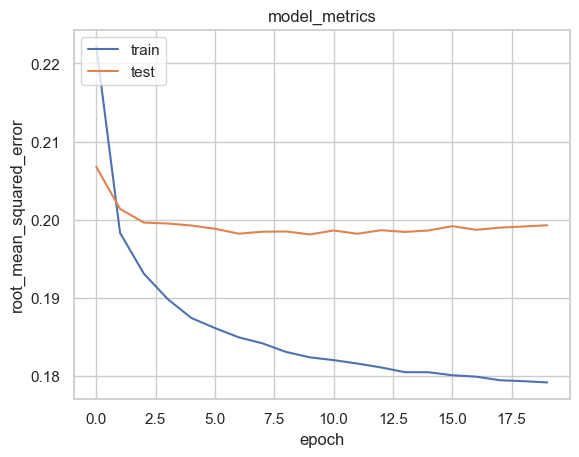

In [40]:
plt.plot(history.history['root_mean_squared_error'])
plt.plot(history.history['val_root_mean_squared_error'])
plt.title('model_metrics')
plt.ylabel('root_mean_squared_error')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### Mendapatkan Rekomendasi Film untuk User

In [41]:
user_id = ratings.userId.sample(1).iloc[0]
movie_watched_by_user = ratings[ratings.userId == user_id]

movie_not_watched = movies[~movies['movieId'].isin(movie_watched_by_user.movieId.values)]['movieId']
movie_not_watched = list(
    set(movie_not_watched).intersection(set(movie2movie_encoded.keys()))
)

movie_not_watched = [[movie2movie_encoded.get(x)] for x in movie_not_watched]
user_encoder = user2user_encoded.get(user_id)
user_movie_array = np.hstack(
    ([[user_encoder]] * len(movie_not_watched), movie_not_watched)
)

ratings_pred = model.predict(user_movie_array).flatten()

top_ratings_indices = ratings_pred.argsort()[-10:][::-1]
recommended_movie_ids = [
    movieencoded2movie.get(movie_not_watched[x][0]) for x in top_ratings_indices
]

print('Showing recommendations for users: {}'.format(user_id))
print('===' * 9)
print('Movie with high ratings from user')
print('----' * 8)

top_movie_user = (
    movie_watched_by_user.sort_values(
        by='rating',
        ascending=False
    )
    .head(5)
    .movieId.values
)

movie_df_rows = movies[movies['movieId'].isin(top_movie_user)]
for row in movie_df_rows.itertuples():
    print(row.title, ':', row.genres)

print('----' * 8)
print('Top 10 movie recommendations')
print('----' * 8)

recommended_movies = movies[movies['movieId'].isin(recommended_movie_ids)]
for row in recommended_movies.itertuples():
    print(row.title, ':', row.genres)

220/220 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step   
Showing recommendations for users: 414
Movie with high ratings from user
--------------------------------
American President, The (1995) : Comedy|Drama|Romance
Vertigo (1958) : Drama|Mystery|Romance|Thriller
Rear Window (1954) : Mystery|Thriller
Band of Brothers (2001) : Action|Drama|War
Baby Driver (2017) : Action|Crime|Thriller
--------------------------------
Top 10 movie recommendations
--------------------------------
Kolya (Kolja) (1996) : Comedy|Drama
Man Bites Dog (C'est arrivé près de chez vous) (1992) : Comedy|Crime|Drama|Thriller
Guess Who's Coming to Dinner (1967) : Drama
Gallipoli (1981) : Drama|War
Trial, The (Procès, Le) (1962) : Drama
Adam's Rib (1949) : Comedy|Romance
Neon Genesis Evangelion: The End of Evangelion (Shin seiki Evangelion Gekijô-ban: Air/Magokoro wo, kimi ni) (1997) : Action|Animation|Drama|Fantasy|Sci-Fi
Sophie Scholl: The Final Days (Sophie Scholl - Die letzten Tage) (2005) : Drama|War
Tekkonkinkreet (Tekkon 